In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rouge import Rouge
import sklearn
import paddle

# 1.数据分析

In [2]:
#读取训练文件数据
txt_path='data/train_dataset.csv'
#读取训练数据文件
data=pd.read_csv(txt_path,encoding='utf-8',sep='|')
#打印查看数据样例
data.head(5)

,id,content,abstract
0,0,【坐席】您好，实习话务员为您，【客户】服务，喂，你好，是这样的，我那个我的电话因为上次突然把...,用户来电反映手机号卡收费问题，用户称现在怎么欠费167.65，我方经查询用户有10月欠费76...
1,1,【客户】嗯，【坐席】，很高兴为您服务，【客户】喂，你好，你好，我想问一下，我没有去过这个吉林...,用户来电反映查询漫游地，显示有吉林，用户称没有去过附近，要求核实回复，请处理谢谢
2,2,【客户】嗯，【坐席】，您好，实习话务员为您服务，【客户】喂你好，然后我这某某人卡，然后有有两...,用户来电想要取消20元语音特惠包（200分钟另得100条短信）-立即生效，我方取消不成功，用...
3,3,【坐席】很高兴为您服务，您好？【客户】，唉，您好，那个，我这手机号上个月就是因为我每个月固定...,用户来电反映自己手机号码在7月份24.10元 8月份元 11月份85.90元 12月份300...
4,4,【坐席】您好，高兴为您服务，【客户】，唉，你好那个，我家里这个***不太好，【坐席】信号不好...,非常感谢您向我们提供这些宝贵信息，我们已经对您反应的问题进行记录反馈，同时我公司也会持续优化...


## 1.1 分析文本与摘要长度

In [3]:
#计算最大的内容和摘要长度
def max_text_len(self):
    for i, col in enumerate(self):
        data[col] = data[col].astype(str)
        n_max = data[col].str.len().max()
        print(i, col, n_max)
#计算平均的内容和摘要长度
def avg_text_len(self):
    for i, col in enumerate(self):
        data[col] = data[col].astype(str)
        n_mean = data[col].str.len().mean()
        print(i, col, n_mean)
def sort_data(data):
    content_np = np.array(data['content'].astype(str).str.len())
    content_np = np.sort(content_np)
    return content_np
content_np = np.array(data['content'].astype(str).str.len())
content_np = np.sort(content_np)

abstract_np = np.array(data['abstract'].astype(str).str.len())
abstract_np = np.sort(abstract_np)

Rectangle(xy=(2164.76, 0), width=97.58, height=287, angle=0)


Text(1220.2227910883564, 2000, '数据均值为1215.22')

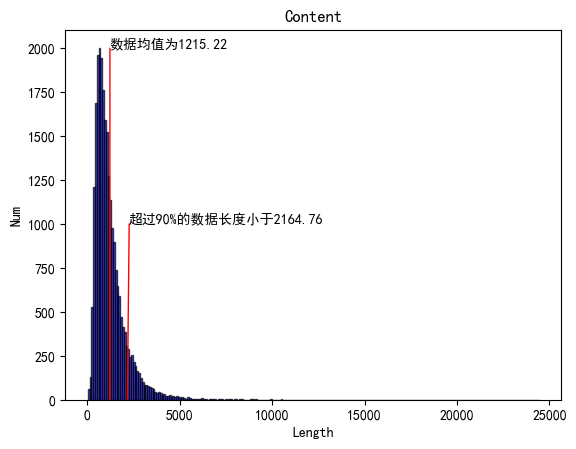

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 生成25000个随机数据作为示例
data = content_np
avg = data.mean()
# 将数据分成250组
n,bins,patches = plt.hist(data, bins=250, facecolor="blue", edgecolor="black", alpha=0.7)
plt.xlabel("Length")
plt.ylabel("Num")
# 添加标签和标题
plt.title('Content')
num = 0
futher_90data = 0
for patche in patches:
    # print(i.get_height())
    num += patche.get_height()
    if num >= 25000*0.9:
        futher_90data = patche
        break
print(futher_90data)
plt.plot([futher_90data.get_x(),futher_90data.get_x()+futher_90data.get_width()],[0,1000],color='red',linewidth=1)
plt.plot([avg,avg+5],[0,2000],color='red',linewidth=1)
plt.text(futher_90data.get_x()+futher_90data.get_width()/2,1000,f'超过90%的数据长度小于{futher_90data.get_x()}',fontsize=10)
plt.text(avg+5,2000,f'数据均值为{round(avg,2)}',fontsize=10)

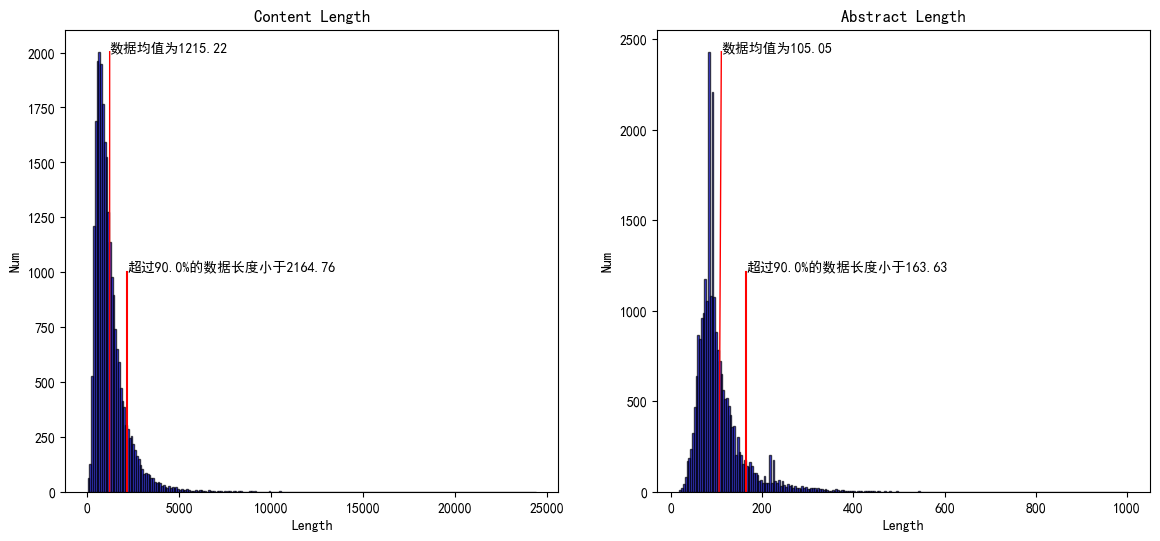

In [5]:
def plot_anlysis(data,title,persent = 0.9):
    avg = data.mean()
    # 将数据分成250组
    n,bins,patches = plt.hist(data, bins=250, facecolor="blue", edgecolor="black", alpha=0.7)
    plt.xlabel("Length")
    plt.ylabel("Num")
    # 添加标签和标题
    plt.title(title)
    num = 0
    futher_data = 0
    max_lenth = 0
    for patche in patches:
        num += patche.get_height()
        if patche.get_height() > max_lenth:
            max_lenth = patche.get_height()
        if num >= 25000*persent:
            futher_data = patche
            break
    # print(futher_data)
    plt.plot([futher_data.get_x(),futher_data.get_x()],[0,max_lenth/2],color='red',linewidth=1.5)
    plt.plot([avg,avg+5],[0,max_lenth],color='red',linewidth=1)
    plt.text(futher_data.get_x()+futher_data.get_width()/2,max_lenth/2,f'超过{persent*100}%的数据长度小于{round(futher_data.get_x(),2)}',fontsize=10)
    plt.text(avg+5,max_lenth,f'数据均值为{round(avg,2)}',fontsize=10)
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plot_anlysis(content_np,'Content Length')
plt.subplot(1,2,2)
plot_anlysis(abstract_np,'Abstract Length')


## 1.2 对话长度分析

In [6]:
import re
data=pd.read_csv(txt_path,encoding='utf-8',sep='|')
# sentence = data['content'][0]
#
# # 定义正则表达式模式，匹配 "【坐席】" 或 "【客户】" 以及对应的内容
# pattern = r"(【坐席】.*?)(?=(?:【坐席】|【客户】|$))|(【客户】.*?)(?=(?:【坐席】|【客户】|$))"
# # 使用正则表达式进行匹配，并返回所有匹配结果
# matched_sentences = re.findall(pattern, sentence)
# print(matched_sentences)
# 输出匹配的句子，包括标记
# for matched_sentence in matched_sentences:
#     print(matched_sentence[0] or matched_sentence[1])
def get_dialogue_num(data):
    dialogue_num = []
    zuoxi_num = []
    kehu_num = []
    pattern = r"(【坐席】.*?)(?=(?:【坐席】|【客户】|$))|(【客户】.*?)(?=(?:【坐席】|【客户】|$))"
    for sentence in data:
        zuoxi_total_num = 0
        kehu_total_num = 0
        zuoxi_dia_num = 1
        kehu_dia_num = 1
        matched_sentences = re.findall(pattern, sentence)
        dialogue_num.append(len(matched_sentences))
        for matched_sentence in matched_sentences:
            if matched_sentence[0]:
                zuoxi_dia_num += 1
            else:
                kehu_dia_num += 1
            zuoxi_total_num += len(matched_sentence[0])
            kehu_total_num += len(matched_sentence[1])
        zuoxi_num.append(zuoxi_total_num/zuoxi_dia_num+1)
        kehu_num.append(kehu_total_num/kehu_dia_num)
    return dialogue_num ,zuoxi_num,kehu_num
dia_num,zuoxi_num,kehu_num =  get_dialogue_num(data['content'])

In [7]:
#异常数据处理
for i in range(len(zuoxi_num)):
    if zuoxi_num[i] > 500:
        print(f"{i}:{zuoxi_num[i]}")
        zuoxi_num[i] = 500

448:751.0
2684:1025.0
9018:647.5
11247:1000.0
11457:532.2307692307693
11494:3141.5
12372:673.2
14775:4592.0
18746:2952.0
19466:1166.0


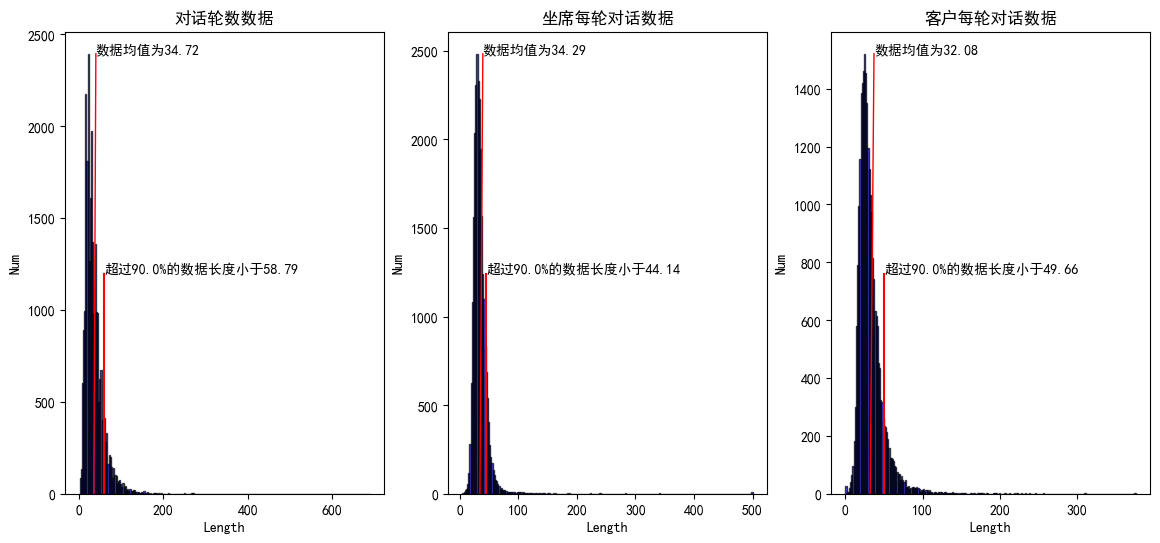

In [8]:
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plot_anlysis(np.array(dia_num),'对话轮数数据',persent=0.9)
plt.subplot(1,3,2)
plot_anlysis(np.array(zuoxi_num),'坐席每轮对话数据',persent=0.9)
plt.subplot(1,3,3)
plot_anlysis(np.array(kehu_num),'客户每轮对话数据',persent=0.9)

# 2 数据预处理
## 2.1 数据清洗
### 2.1.1 去除问候语
1. 考虑清洗前几句问候的话语,对于以【客户】开头的数据，存在4种语言情况：
    - 标注错误。许多以【客户】开头的长句中，都包含了【坐席】的第一句话“您好，很高兴为您服务”等字眼，但这些内容没有被区分出来，而是被一股脑塞进了【客户】的语句中。这类语句的第一句长度一般大于25，不需要去除，“您好”等错误混入的语句可以通过后面的关键词筛除步骤去除；第二句不需要去除。
    - 用户直接抛出问题。用户没有等【坐席】说出基本的问候语就直接抛出问题，【坐席】紧接着进行询问和解决。这类语句的第一句长度一般大于25，不需要去除；第二句不需要去除。
    - 回访电话。回访电话是由通话公司打给用户的，因此第一句一般是用户的“喂”“你好”等回应。这类语句的第一句长度一般小于25，需要去除；第二句说明主要问题，语句长度大于20，不需要去除。
    - 互相问候。【客户】和【坐席】彼此问候，语句都比较短，基本没有实质意义。第一句和第二句都需要去除。

    基于上述4种语言情况，需要做的处理为：对于以【客户】开头的数据:
    - 先判断第一句长度是否大于25，是则不用去除任何内容；否则去除第一句，并进行下一步筛选。
    - 判断第二句长度是否大于20，是则不用去除；否则去除第二句。

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rouge as rg
import sklearn
import paddle
#读取训练文件数据
txt_path='./data/train_dataset.csv'
#读取训练数据文件
data=pd.read_csv(txt_path,encoding='utf-8',sep='|')
data['content'].str.len().describe()

count    25001.000000
mean      1215.222791
std        982.073521
min         18.000000
25%        636.000000
50%        969.000000
75%       1488.000000
max      24413.000000
Name: content, dtype: float64

In [10]:
data["content"][0]

'【坐席】您好，实习话务员为您，【客户】服务，喂，你好，是这样的，我那个我的电话因为上次突然把给我停机了，我不知道啥意思，然后我就好长时间没有使用，我这次拿着10，怎么我欠费160多了？噢，我想问一下，我这机器现在是在停机状态吧，【坐席】嗯，对是的？【客户】对停机状态，你们怎么还收我费用啊，【坐席】嗯，您稍等这边看的话，先生，咱们这12月份的话是没有收您的费用的，这边是这个产生的费用是您11月份的女士先生，【客户】那我11月份我现在-160，那我想问一下，那我这个怎么能-160？我始终没超一个星期，他就你们就给我停机了，因为那我忙着在外地出差，我就没有，我就没有那个办这个找你们，【坐席】嗯，先生这边看的话，先生，您是一个就是11月份的话，有一个是，嗯，基本套餐费是88块钱，还有您上个月未结清的话费是76块钱，【客户】但是我刚才你们给我反馈那个是我欠160多，【坐席】嗯，对是的先生，就是您这160多，嗯，160多是产生的，是11月份的结转11月份的，总消费是88，还有您10月还有一个是10月份未结清的话，是76块钱？【客户】我没有结清的，我就想问你，你帮我查一下，我打几天电话，我哪来的那个？还有那么多没结清呢，我就不明白，我一个包月电话我都没有打出去多少电话，我这流我这是4000分钟，是两三千分钟啊，那那么多话费我根本都没有打几个，他怎么就我又欠那么多钱呢【坐席】嗯，先生，您这个是阿里大包，嗯，就是三角大大宝卡吗？先生每个月基本月租费是88块钱的，里面是给您包含500分钟通话工作，工作员是二百两千五百分钟，相当于3000分钟吗？先生，还有两个G的流量，【客户】对呀，【坐席】嗯，它这个是如果您，嗯没有超出的话，每个月是收您88块钱的先生，【客户】对呀，那我也没有超出啊，你怎么还有我查，我这还欠那么多费呢【坐席】这嗯，就每个月正常扣您的套餐费用，先生88块钱套餐费用，先生这个是，【客户】对，但是我这个你看一下，你看看你从我开始，我注册这号到停机，您看看我使这几天你你对你们，你查一下看我使了几天，我怎么的就是有这个还有欠费呢，我这还没，我还说实在我找你们，我这使那几天，我那88块钱你们都给我退我，【坐席】嗯这边看的话是在9月份给您给您停的机先生，【客户】对啊，9月份我是9月几号开通的这个卡呀【坐席】嗯，您这是9月1号给您开通的卡先生，【客户】对9月份9月1号开通卡，应该没超

In [11]:
def process_1(data):
    all_conts = [] #所有对话内容，按照【客服】，【用户】句子分割
    cont = data['content']
    cont = cont.str.replace('【','\【')
    client_front_conts = []
    for sen in cont:
        cut = sen.split("\\")[1:]
        all_conts.append(cut)
        if cut[0][1:3] == "客户":
            client_front_conts.append(cut[0] + cut[1])
    for i in range(len(all_conts)):
        each_cont = all_conts[i]
        if len(each_cont[0]) <= 25:
            each_cont = each_cont[1:]
            if len(each_cont[0]) <= 20:
                each_cont = each_cont[1:]
        all_conts[i] = ("".join(each_cont))
    return all_conts
data['content'] = process_1(data)

In [12]:
data['content'].str.len().describe()

count    25001.000000
mean      1199.185073
std        981.845774
min          0.000000
25%        620.000000
50%        952.000000
75%       1472.000000
max      24398.000000
Name: content, dtype: float64

In [13]:
data["content"][0]

'【客户】服务，喂，你好，是这样的，我那个我的电话因为上次突然把给我停机了，我不知道啥意思，然后我就好长时间没有使用，我这次拿着10，怎么我欠费160多了？噢，我想问一下，我这机器现在是在停机状态吧，【坐席】嗯，对是的？【客户】对停机状态，你们怎么还收我费用啊，【坐席】嗯，您稍等这边看的话，先生，咱们这12月份的话是没有收您的费用的，这边是这个产生的费用是您11月份的女士先生，【客户】那我11月份我现在-160，那我想问一下，那我这个怎么能-160？我始终没超一个星期，他就你们就给我停机了，因为那我忙着在外地出差，我就没有，我就没有那个办这个找你们，【坐席】嗯，先生这边看的话，先生，您是一个就是11月份的话，有一个是，嗯，基本套餐费是88块钱，还有您上个月未结清的话费是76块钱，【客户】但是我刚才你们给我反馈那个是我欠160多，【坐席】嗯，对是的先生，就是您这160多，嗯，160多是产生的，是11月份的结转11月份的，总消费是88，还有您10月还有一个是10月份未结清的话，是76块钱？【客户】我没有结清的，我就想问你，你帮我查一下，我打几天电话，我哪来的那个？还有那么多没结清呢，我就不明白，我一个包月电话我都没有打出去多少电话，我这流我这是4000分钟，是两三千分钟啊，那那么多话费我根本都没有打几个，他怎么就我又欠那么多钱呢【坐席】嗯，先生，您这个是阿里大包，嗯，就是三角大大宝卡吗？先生每个月基本月租费是88块钱的，里面是给您包含500分钟通话工作，工作员是二百两千五百分钟，相当于3000分钟吗？先生，还有两个G的流量，【客户】对呀，【坐席】嗯，它这个是如果您，嗯没有超出的话，每个月是收您88块钱的先生，【客户】对呀，那我也没有超出啊，你怎么还有我查，我这还欠那么多费呢【坐席】这嗯，就每个月正常扣您的套餐费用，先生88块钱套餐费用，先生这个是，【客户】对，但是我这个你看一下，你看看你从我开始，我注册这号到停机，您看看我使这几天你你对你们，你查一下看我使了几天，我怎么的就是有这个还有欠费呢，我这还没，我还说实在我找你们，我这使那几天，我那88块钱你们都给我退我，【坐席】嗯这边看的话是在9月份给您给您停的机先生，【客户】对啊，9月份我是9月几号开通的这个卡呀【坐席】嗯，您这是9月1号给您开通的卡先生，【客户】对9月份9月1号开通卡，应该没超过，9月10号，你就把我这个停

### 2.1.2 停用词替换

In [14]:
import json
# 读入txt文件
stopwords_path = './util/stopwords.txt'
stopwords = [line.strip() for line in open(stopwords_path, 'r', encoding='utf-8').readlines()]
# 构造停用词词典
stopwords_dict = dict(zip(stopwords, ["" for i in range(len(stopwords))]))
with open("./util/replace_dict.json", "r") as f:
    replace_dict = json.load(f)
# print(stopwords_dict)
# print(replace_dict)
# 合并两个词典
stopwords_dict.update(replace_dict)
print(stopwords_dict)
# 保存词典
with open("./util/stopwords_dict.json", "w") as f:
    json.dump(stopwords_dict, f, ensure_ascii=False, indent=4)
replace_dict = stopwords_dict

{'?': '', '、': '', '。': '，', '“': '', '”': '', '《': '', '》': '', '！': '', '，': '', '：': '', '；': '', '？': '，', '先生': '', '嗯': '', '您说': '', '啊': '', '哎': '', '哎呀': '', '哎哟': '', '唉': '', '俺': '', '俺们': '', '按照': '', '吧哒': '', '罢了': '', '本着': '', '比方': '', '比如': '', '鄙人': '', '彼此': '', '别的': '', '别说': '', '并且': '', '不比': '', '不成': '', '不单': '', '不但': '', '不独': '', '不管': '', '不光': '', '不过': '', '不仅': '', '不拘': '', '不论': '', '不怕': '', '不然': '', '不如': '', '不特': '', '不惟': '', '不问': '', '不只': '', '朝着': '', '趁': '', '趁着': '', '除此之外': '', '除非': '', '除了': '', '此间': '', '此外': '', '从而': '', '但是': '', '当着': '', '的话': '', '等等': '', '地': '', '叮咚': '', '对于': '', '多少': '', '而': '', '而况': '', '而且': '', '而是': '', '而外': '', '而言': '', '而已': '', '尔后': '', '反过来': '', '反过来说': '', '反之': '', '非但': '', '非徒': '', '否则': '', '嘎': '', '嘎登': '', '各个': '', '各位': '', '各种': '', '各自': '', '根据': '', '故此': '', '固然': '', '关于': '', '果然': '', '果真': '', '哈': '', '哈哈': '', '呵': '', '何处': '', '何况': '', '何时': '', '嘿': '', '哼': '

In [15]:
def process_2(data,replace_dict):
    temp_data = data['content']
    for i,j in replace_dict.items():
        temp_data = temp_data.str.replace(i,j)
    return temp_data
data['content'] = process_2(data,replace_dict)

In [16]:
data['content'].str.len().describe()

count    25001.000000
mean       811.309628
std        674.432359
min          0.000000
25%        415.000000
50%        641.000000
75%        998.000000
max      17099.000000
Name: content, dtype: float64

In [17]:
data["content"][0]

'【客户】服务是的我个我的电话上次突然把给我停机我不知道意思我就好长时间没有使用我这次拿着10怎我欠费160多，我想问我这机器现在是在停机状态吧【坐席】对，【客户】对停机状态怎还收我费用【坐席】看们这12月份是没有收的费用的是产生的费用是11月份的【客户】我11月份我现在-160我想问我怎能-160，我始终没超星期他就就给我停机我忙着在外出差我就没有我就没有个办找【坐席】看是11月份有是基本套餐费是88块钱上个月未结清费是76块钱【客户】我刚才给我反馈个是我欠160多【坐席】对这160多160多是产生的是11月份的结转11月份的总消费是8810月是10月份未结清是76块钱，【客户】我没有结清的我就想问你帮我查我打几天电话我来的个，多没结清我就不明白我包月电话我都没有打出去电话我这流我这是4000分钟是两三千分钟多话费我根本都没有打几个他怎就我又欠多钱【坐席】是阿里大包三角大大宝卡，每个月基本月租费是88块钱的里面是给包含500分钟通话工作工作员是二百两千五百分钟相当于3000分钟，两个G的流量【客户】对【坐席】它是没有超出每个月是收88块钱的【客户】对我没有超出你怎我查我这还欠多费【坐席】这就每个月正常扣的套餐费用88块钱套餐费用是【客户】对我你看你看看你从我注册这号到停机看看我使这几天你对你查看我使几天我怎的有欠费我这还没我还说实在我找我这使几天我88块钱都给我退我【坐席】看是在9月份给给停的机【客户】对9月份我是9月几号开通的卡【坐席】这是9月1号给开通的卡【客户】对9月份9月1号开通卡应该没超过9月10号你就把我停应该【坐席】【客户】对你说觉得我怎弄你说我该怎弄，觉得问问公司领导我怎能查算合理【坐席】看好吧问题们给记录反馈稍后有们的专员给回电到底是问题给解决，看吧【客户】行你【坐席】就联系好联系电话联系个手机号码【客户】你就联系就行【坐席】不是已经是给暂停服务就怕们联系是无法无法接听电话的无法打通的【客户】他给我打个1851851951【坐席】*就联系号码【客户】4089对【坐席】看什问题帮的，【客户】没有你再给我把这给我解决吧好吧【坐席】好好的【客户】【坐席】感谢的来电请稍后对服务评价中帮我按个十分满意谢谢'

### 2.1.3 去除短句子
根据对数据的观察和经验，大部分字数少于6个字的语句都是无意义的语句，可以被去除。

In [18]:
def process_3(data):
    all_conts = []
    cont = data['content']
    cont = cont.str.replace('【','\【')

    all_conts = [sen.split("\\")[1:] for sen in cont]
    def delete_short(x):
        return len(x) > 6
    for i in range(len(all_conts)):
        dialogue = all_conts[i]
        part_sent = ""
        for part in dialogue:
            sent = part[4:]
            sent = sent.replace('。','，')
            sent = sent.replace('？','，')
            sents = sent.split('，')
            sents = filter(delete_short, sents)
            join_sen = "，".join(sents)
            if join_sen != '':
                part_sent += part[:4] + join_sen
        all_conts[i] = part_sent
    return all_conts

In [19]:
data['content'] = process_3(data)
data['content'].str.len().describe()

count    25001.000000
mean       723.343706
std        625.450733
min          0.000000
25%        357.000000
50%        562.000000
75%        892.000000
max      15209.000000
Name: content, dtype: float64

### 2.1.4 更换前缀

In [20]:
def process_4(data):
    replace_dict = {
        "【坐席】":"坐:",
        "【客户】":"客:"
    }

    temp = data['content']
    for i,j in replace_dict.items():
        temp = temp.str.replace(i,j)
    return temp
data['content'] = process_4(data)
data['content'].str.len().describe()

count    25001.000000
mean       675.866725
std        593.572298
min          0.000000
25%        330.000000
50%        522.000000
75%        833.000000
max      15024.000000
Name: content, dtype: float64

In [61]:
import re
sentence = data['content'][0]
# 定义正则表达式模式，匹配 "【坐席】" 或 "【客户】" 以及对应的内容
pattern = r"(【坐席】.*?)(?=(?:【坐席】|【客户】|$))|(【客户】.*?)(?=(?:【坐席】|【客户】|$))"
pattern = r"(坐:.*?)(?=(?:坐:|客:|$))|(客:.*?)(?=(?:坐:|客:|$))"
# 使用正则表达式进行匹配，并返回所有匹配结果
matched_sentences = re.findall(pattern, sentence)
# print(matched_sentences)
# 输出匹配的句子，包括标记
# for matched_sentence in matched_sentences:
#     print(matched_sentence[0] or matched_sentence[1])
def get_dialogue_num(data):
    dialogue_num = []
    zuoxi_num = []
    kehu_num = []
    pattern = r"(坐:.*?)(?=(?:坐:|客:|$))|(客:.*?)(?=(?:坐:|客:|$))"
    for sentence in data:
        zuoxi_total_num = 0
        kehu_total_num = 0
        zuoxi_dia_num = 1
        kehu_dia_num = 1
        matched_sentences = re.findall(pattern, sentence)
        dialogue_num.append(len(matched_sentences))
        for matched_sentence in matched_sentences:
            if matched_sentence[0]:
                zuoxi_dia_num += 1
            else:
                kehu_dia_num += 1
            zuoxi_total_num += len(matched_sentence[0])
            kehu_total_num += len(matched_sentence[1])
        zuoxi_num.append(zuoxi_total_num/zuoxi_dia_num+1)
        kehu_num.append(kehu_total_num/kehu_dia_num)
    return dialogue_num ,zuoxi_num,kehu_num
dia_num,zuoxi_num,kehu_num =  get_dialogue_num(data['content'])

In [62]:
#异常数据处理
for i in range(len(zuoxi_num)):
    if zuoxi_num[i] > 500:
        print(f"{i}:{zuoxi_num[i]}")
        zuoxi_num[i] = 500

2684:682.5
11247:661.5
11494:2188.0
14775:3064.5
18746:1966.5
19466:758.5


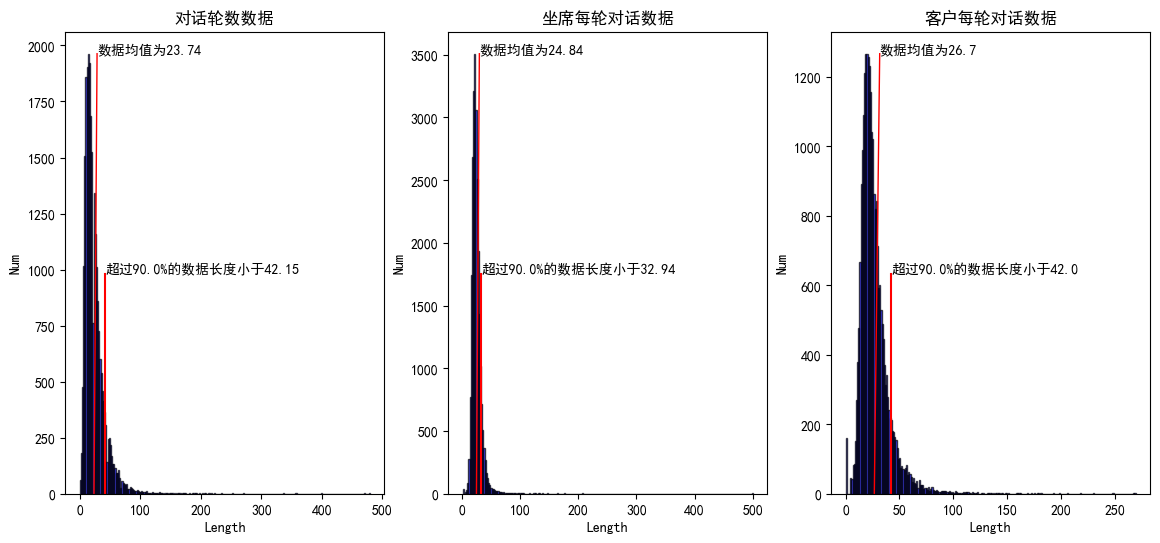

In [63]:
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plot_anlysis(np.array(dia_num),'对话轮数数据',persent=0.9)
plt.subplot(1,3,2)
plot_anlysis(np.array(zuoxi_num),'坐席每轮对话数据',persent=0.9)
plt.subplot(1,3,3)
plot_anlysis(np.array(kehu_num),'客户每轮对话数据',persent=0.9)

### 2.1.5 对于仍然大于512的数据进行分段处理
#### 迭代生成法

In [21]:
from paddlenlp.transformers import PegasusForConditionalGeneration, PegasusChineseTokenizer
from paddlenlp.transformers import LinearDecayWithWarmup
from paddle.io import BatchSampler, DistributedBatchSampler, DataLoader
from paddlenlp.data import DataCollatorForSeq2Seq
model = PegasusForConditionalGeneration.from_pretrained('./61/checkpoints')
model.eval()
tokenizer = PegasusChineseTokenizer.from_pretrained('./61/checkpoints')

D:\Program\Anaconda\envs\paddle\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [22]:
num_beams = 4
max_source_length = 512
min_target_length = 0
max_target_length = 160
def infer(text, model, tokenizer):
    tokenized = tokenizer(text,
                          truncation=True,
                          max_length=max_source_length,
                          return_tensors='pd')
    preds, _ = model.generate(input_ids=tokenized['input_ids'],
                              max_length=160,
                              min_length=min_target_length,
                              decode_strategy='beam_search',
                              num_beams=num_beams)
    return(tokenizer.decode(preds[0], skip_special_tokens=True, clean_up_tokenization_spaces=False))
# 计算训练评估参数Rouge-1，Rouge-2，Rouge-L
rouge = rg.Rouge()
def compute_metrics(rg,preds, targets):
    score = rg.get_scores(' '.join(preds), ' '.join(targets))
    rouge1 = score[0]['rouge-1']['f']
    rouge2 = score[0]['rouge-2']['f']
    rougel = score[0]['rouge-l']['f']
    # print(round(rouge1*100, 2),round(rouge2*100, 2),round(rougel*100, 2))
    score = round((rouge1 * 0.2 + rouge2 * 0.4 + rougel * 0.4) * 100, 2)
    return score

In [97]:
text = data['content'][0]
infer(text[:256]+ text[-256:],model,tokenizer)

'* * * * * * * * 用户来电反映对本机号码停机不认可，经查询是因疑似骚扰停机，已按业务规则解释，用户不认可，称现在不在北京，无法回到北京办理，要求您提供合理解释，请核实处理，谢谢'

In [106]:
print(len(text))
cut =  len(text) / 512
for i in range(int(cut)):
    cut_list = []
    for i in range(int(cut)):
        if i == 0:
            cut_list.append(text[:512])
        if i == int(cut) - 1:
            cut_list.append(text[512*i:])
        else:
            cut_list.append(text[512*i:512*(i+1)])
for i in range(len(cut_list)):
    print(infer(cut_list[i],model,tokenizer))

4076
用户来电反映申请报装的宽带长时间没有人安装，用户不认可，要求我方尽快安排装机人员上门为用户安装，用户要求我方核实订单状态并尽快回复，请处理，谢谢！
用户来电反映申请报装的宽带长时间没有人安装，用户不认可，要求我方尽快安排装机人员上门为用户安装，用户要求我方核实订单状态并尽快回复，请处理，谢谢！
用户来电反映在1月5号通过手厅申请的宽带，订单号* * * * * * * * 和* * * * * * * * ，当时没有人联系用户，用户对此不认可，用户要求投诉，我方已按照前期回复正常向用户解释，用户不认可，详见前期工单ts* * * * * * * * ，称至今未给用户联系，用户有升级投诉倾向，烦请相关人员核实处理并回复，谢谢
用户再次来电反映前期问题，详见工单ts* * * * * * * * ，我方按照前期处理结果正常向用户解释，用户表示强烈不认可，要求我方再次上报，烦请处理，谢谢
用户来电反映自己在11 月份申请了宽带，但是现在没有人联系自己上门安装，称跟单位的工作人员沟通过，对方告知用户时间承诺的时间没有问题，用户对此强烈不认可，称自己明天需要去医院安装，要求我方为其赔偿自己损失，用户有升级投诉倾向，烦请相关人员核实处理并回复，谢谢！
用户来电反映要求我方今天上门安装宽带，用户的电话不是客服电话，用户称自己明天要到营业厅办理业务，用户不认可，有升级投诉倾向，请处理，谢谢！
用户来电要求投诉安装师傅的工作人员，用户称现在欺骗消费20多，对此不认可，我方致歉无效，用户要求我方核实处理并回复，谢谢！
客户来电反映申请报装的宽带长时间没有人安装，用户不认可，要求我方尽快安排装机人员上门为用户安装，我方安抚用户请尽快处理。


In [70]:
new_replace_dict = {
    "* * * * * * * * ": "",
    "要求投诉，": "",
    "要求投诉": "",
    "ts* * * * * * * * ":"",
    "ts* * * * * * * * 、": "",
    "、" : "",
    "请尽快处理并回复": "",
    "请尽快处理并回复，": "",
    "ts": "",
    "【仅适用于用户上网慢现象】": "",
    "详见": "",
    "【客户】": "客:",
    "【坐席】": "坐:",
    "用户": "客:",
    "我方": "坐:",
    "客户": "客:",
    "宝贵信息": "",
    "提供宝贵信息":"",
    "我们已经对您反应的问题进行记录反馈": "",
    "谢谢": "",
    "请处理": "",
    "请处理，": "",
    "非常": "",
    "感谢": "",
    "感谢您的反馈": "",
}

def change_word(text,new_replace_dict):
    for key in new_replace_dict.keys():
        text = text.replace(key, new_replace_dict[key])
    return text

def cut_upper512(text,new_replace_dict):
    text = change_word(text,new_replace_dict)
    if len(text) <= 2048:
        raise ValueError('文本长度小于2048，无需分段')
    text_len = len(text)
    content_len = 512
    cut =  text_len / content_len
    # 切成cut段
    cut_list = []
    for i in range(int(cut)):
        if i == 0:
            cut_list.append(text[:content_len])
        if i == int(cut) - 1:
            cut_list.append(text[content_len*i:])
        else:
            cut_list.append(text[content_len*i:content_len*(i+1)])
    new_text = ''
    for i in range(len(cut_list)):
        new_text += infer(cut_list[i], model, tokenizer)
    temp = change_word(new_text,new_replace_dict)
    if len(temp) > 2048:
        temp = cut_upper512(temp,new_replace_dict)
    else:
        temp = temp[:256] + temp[-256:]
    return temp

1. 如果小于512，直接塞进去
2. 如果大于512小于1024，首先预测中间一段：text[256:256+512]，计算中间一段长度，mid_len=len(infer(change(text[256:256+512]))),然后去两边的长度为(512-mid_len)/2的文本，分别预测，然后拼接。
3. 如果小于2048，取文本的前51后512，分别预测，然后拼接。

In [68]:
def process_cut(text,new_replace_dict):
    if len(text) <= 512:
        # print('小于512')
        return text
    elif len(text) <= 600:
        # print('小于600')
        return text[:256] + text[-256:]
    elif len(text) <= 2048:
        # print('小于2048')
        mid_text = text[256:-256]
        mid_text = mid_text[:256] + mid_text[-256:]
        mid_text = infer(mid_text, model, tokenizer)
        mid_text = change_word(mid_text,new_replace_dict)
        mid_len = len(mid_text)
        text1 = text[:(256-mid_len//2)] + mid_text + text[-(256-mid_len//2):]
        return text1
    else:
        # print('大于2048')
        return cut_upper512(text,new_replace_dict)

#### TextRank法

In [103]:
#-*- encoding:utf-8 -*-
import codecs
from textrank4zh import TextRank4Keyword, TextRank4Sentence
cnt =  0
for i in range(7525):
    if(len(data['content'][i])>3000):
        text = data['content'][i]
        cnt += 1
        if cnt > 0:
            break
abstract__ = data['abstract'][i]
tr4s = TextRank4Sentence(delimiters=[ '客:','坐'], stop_words_file='./util/stopwords.txt')
tr4s.analyze(text=text, lower=True, source = 'all_filters')
sen = tr4s.get_key_sentences(num=100000,sentence_min_len = 5)
print( '摘要：' )
print("rank","idx    ","权重    ","句子")
for idx,item in enumerate(sen):
    print(idx,"\t",item.index, " \t",round(item.weight,3), "\t",item.sentence)  # index是语句在文本中位置，weight是权重
processed_text = ""
for idx, item in enumerate(sen):
    processed_text += item.sentence
    if len(processed_text) > 512:
        break

text = text.replace("坐:","").replace("客:","")
print("TextRank",compute_metrics(rouge,processed_text,abstract__))
print(len(text))

摘要：
rank idx     权重     句子
0 	 2  	 0.035 	 对下单之后给我给我网页让我在上面交钱我都已经交好几天已经付过款是，早就已经输完现在是属我前在压着不给我安装就付对吧对我再帮后台核实我这有这下载的订单交叉口的方电话要，提供*好听到音乐后不要挂机我在后台帮看好我查看到订单状态我再给催办再耐心等待我在办的跟我说48小时给我安装后来你客服的没有给我安装上我就没有我没有怪不知道我就停两停吧我前两天下来之后还让我一等再等问题我看已经有个上报的记录我对你看见我已经上报并没有人搭理我是它是是48小时之内给回复再耐心等待这两个问题我都给过5号就算是我5号投诉过问题现在过没过48小时有人联系我，我看订单催办时间看是在1月6号的来电给上报问题我1月5号就已经反映过事说客服并没有给我上报1月5号九点看到八点八点十二对8:12为什48小时过去还没有人联系我，今天是7号我只能是再给催办我把钱放在联通联通只能营业厅给我催确实不给我办十块是，是需要后台的人员
1 	 4  	 0.035 	 是需要后台的人员回复我已经接受的个规则我等等之后并没有人联系我你理解我，我不可能天天都请假在家等着安装你的宽带是，个是今天已经10号我本来是我本来是3号的办的我在家等四天我抢四天的假是工作人员的失误为什要让我承担后果，我在前面我工作都不保很抱歉我理解的心情问题确实是需要后台人员给回复的我给解决不只能是再给催办说联通现在就不做为是，我给答电话是不好使的我办是不是在这办的你跟我说后台后台联系我是不是打电话办的你现在现在就属于拒绝不给我提供装机师傅的电话拒绝给我处理问题没给我往相关部门上报你就只能让我等我怎整，问题是已经上报的你上报有人联系我你上报之后有用，你上报完之后48小时根本就没有人联系我你现在再给我上报48小时没有人联系我有用，我直接给催办就的让再尽快跟联系5号个客服这跟我说的我实在是没有耐心今天设备设备给我解决解决不我肯定是不能挂电话的这什号便宜的人跟给没
2 	 1  	 0.031 	 看1月5号的已经重新给登记下单还没有人联系是，对根本就没有人联系我昨天给客服打电话你不是必须得是本人拿身份证在家等着，我都我都说我都说3号天我办业务是人工客服她给我个发的失误他给我弄错它5号又重新给我下一笔我就请假在家等着这两天又没有人联系我实在是没有办法再请假好的先听到音乐后不要

In [111]:
#-*- encoding:utf-8 -*-
import codecs
from textrank4zh import TextRank4Keyword, TextRank4Sentence
cnt =  0
scor1_list = []
scor2_list = []
scor3_list = []
for i in range(25000):
    if(len(data['content'][i])>512):
        text = data['content'][i]
        cnt += 1
        abstract__ = data['abstract'][i]
        tr4s = TextRank4Sentence(delimiters=[ '客:','坐'], stop_words_file='./util/stopwords.txt')
        tr4s.analyze(text=text, lower=True, source = 'all_filters')
        sen = tr4s.get_key_sentences(num=100000,sentence_min_len = 5)
        # print( '摘要：' )
        # for item in tr4s.get_key_sentences(num=40,sentence_min_len = 5):
        #     print(item.index, item.weight, item.sentence)  # index是语句在文本中位置，weight是权重
        # print(tr4s.get_key_sentences(num=40,sentence_min_len = 5))
        processed_text = ""
        for idx, item in enumerate(sen):
            processed_text += item.sentence
            if len(processed_text) > 512:
                break
        new_content = process_cut(text,new_replace_dict)
        text = text.replace("坐:","").replace("客:","")
        # print("原文",compute_metrics(rouge,text,abstract__))
        score1 = compute_metrics(rouge,new_content,abstract__)
        score2 = compute_metrics(rouge,processed_text,abstract__)
        score3 = compute_metrics(rouge,text[:256] + text[-256:],abstract__)
        print("迭代抽取",score1,"TextRank",score2,"前后抽取",score3)
        scor1_list.append(score1)
        scor2_list.append(score2)
        scor3_list.append(score3)

迭代抽取 24.88 TextRank 23.52 前后抽取 25.37
迭代抽取 14.88 TextRank 15.1 前后抽取 14.89
迭代抽取 24.61 TextRank 22.9 前后抽取 17.33
迭代抽取 14.77 TextRank 11.63 前后抽取 9.88
迭代抽取 25.77 TextRank 21.45 前后抽取 19.16
迭代抽取 24.58 TextRank 24.76 前后抽取 24.4
迭代抽取 24.33 TextRank 18.0 前后抽取 20.13
迭代抽取 31.83 TextRank 26.59 前后抽取 26.02
迭代抽取 20.83 TextRank 20.12 前后抽取 21.83
迭代抽取 24.42 TextRank 10.83 前后抽取 16.92
迭代抽取 18.14 TextRank 18.65 前后抽取 17.96
迭代抽取 18.48 TextRank 16.98 前后抽取 17.52
迭代抽取 24.39 TextRank 20.91 前后抽取 22.56
迭代抽取 36.99 TextRank 27.57 前后抽取 27.47
迭代抽取 26.53 TextRank 24.28 前后抽取 26.48
迭代抽取 23.49 TextRank 10.37 前后抽取 15.83
迭代抽取 14.67 TextRank 14.94 前后抽取 16.72
迭代抽取 24.06 TextRank 15.56 前后抽取 12.23
迭代抽取 23.55 TextRank 21.79 前后抽取 22.19
迭代抽取 19.28 TextRank 19.14 前后抽取 19.23
迭代抽取 27.33 TextRank 25.81 前后抽取 27.91
迭代抽取 17.69 TextRank 14.39 前后抽取 14.56
迭代抽取 19.17 TextRank 17.28 前后抽取 18.76
迭代抽取 18.85 TextRank 19.04 前后抽取 19.8
迭代抽取 16.88 TextRank 18.01 前后抽取 17.12
迭代抽取 21.26 TextRank 17.15 前后抽取 19.63
迭代抽取 16.76 TextRank 15.3 前后抽取 14.67
迭代抽取 31.

[<matplotlib.patches.PathPatch object at 0x000001B3BBC74760>, <matplotlib.patches.PathPatch object at 0x000001B48EB6AB20>, <matplotlib.patches.PathPatch object at 0x000001B48ECD2490>]


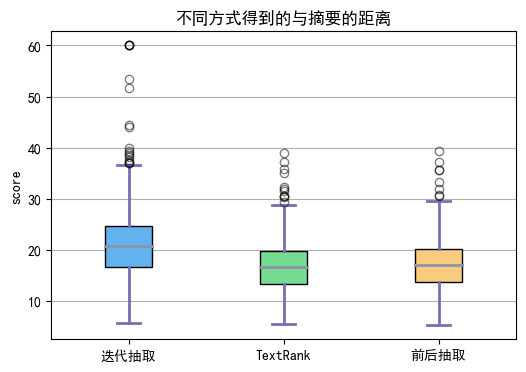

In [33]:
# 绘制线箱图
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# 合并数据 该数据之前已经写过，现在只需要读取即可
# concat_data = np.vstack([np.array(scor1_list),np.array(scor2_list),np.array(scor3_list)])
# pd.DataFrame(concat_data.T).to_csv("data1111.csv",index=False)
concat_data = pd.read_csv("result/compare_method.csv")
concat_data_1 = concat_data.to_numpy().T
#首先有图（fig），然后有轴（ax）
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(6,4))


bplot1=ax.boxplot(concat_data_1.T,
                       vert=True,
                       patch_artist=True)

#
# bplot2 = axes[1].boxplot(concat_data.T,
#                          notch=True,
#                          vert=True,
#                          patch_artist=True)
print(bplot1['boxes'])
#颜色填充
colors = ['#63b2ee', '#76da91', '#f8cb7f']
for bplot in (bplot1):
    for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)
    for whisker in bplot1['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)
    for cap in bplot1['caps']:
        cap.set(color='#7570b3', linewidth=2)
    for median in bplot1['medians']:
        median.set(color='#9192ab', linewidth=2)
    for flier in bplot1['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)

# 加水平网格线
ax.yaxis.grid(True) #在y轴上添加网格线
ax.set_xticks([y+1 for y in range(len(concat_data_1))] ) #指定x轴的轴刻度个数
## [y+1 for y in range(len(all_data))]运行结果是[1,2,3]
ax.set_ylabel('score') #设置x轴名称
ax.set_title('不同方式得到的与摘要的距离') #设置图表名称
plt.setp(ax, xticks=[1,2,3],
        xticklabels=["迭代抽取","TextRank","前后抽取"])
plt.show()

可以看出TextRank方法和前后抽取方法得分均小于迭代抽取，因此最后选择迭代抽取法

In [38]:
import tqdm
cnt = 0
res_list = []
temp_content = data['content']
for i in tqdm.tqdm(range(len(data['content'])),desc='生成数据：'):
    content = data['content'][i]
    cnt += 1
    new_content = process_cut(content,new_replace_dict)
    temp_content[i] = new_content
    ########## 结果展示 ##########
    # print(f"{len(content)}->{len(new_content)}")
    # ori_content = content if (len(content) < 512) else  content[:256] + content[-256:]
    # res1 = compute_metrics(rouge,new_content,data['abstract'][i])
    # res2 = compute_metrics(rouge,content,data['abstract'][i])
    # print(f"res1:{res1},res2:{res2},loss:{res1-res2}")
    # print("------------------")
    ############################

生成数据：:   0%|                                                                             | 0/7526 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\CYBERL~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.533 seconds.
Prefix dict has been built successfully.
生成数据：: 100%|████████████████████████████████████████████████████████████████| 7526/7526 [2:26:30<00:00,  1.17s/it]


In [39]:
data['content'] = temp_content

In [40]:
temp_content.str.len().describe()

count    7526.000000
mean      421.478209
std       120.534934
min         0.000000
25%       334.000000
50%       512.000000
75%       512.000000
max       513.000000
Name: content, dtype: float64

In [41]:
data['content'].str.len().describe()

count    7526.000000
mean      421.478209
std       120.534934
min         0.000000
25%       334.000000
50%       512.000000
75%       512.000000
max       513.000000
Name: content, dtype: float64

In [43]:
# 保存生成的文件
data.to_csv('./proceed/test_data.csv',  index=False,encoding='utf-8',sep ='|',header =['id','content'])

# 3 训练时的结果查看以及一些数据可视化

In [266]:

warmup = 0.02
learning_rate = 5e-5
num_epochs =30
num_training_steps = 150000
weight_decay=0.01
adam_epsilon = 1e-6
lr_scheduler = LinearDecayWithWarmup(learning_rate, num_training_steps, warmup)
decay_params = [
    p.name for n, p in model.named_parameters()
    if not any(nd in n for nd in ["bias", "norm"])
]
# 优化器AdamW
optimizer = paddle.optimizer.AdamW(
    learning_rate=lr_scheduler,
    beta1=0.9,
    beta2=0.999,
    epsilon=adam_epsilon,
    parameters=model.parameters(),
    weight_decay=weight_decay,
    apply_decay_param_fun=lambda x: x in decay_params)

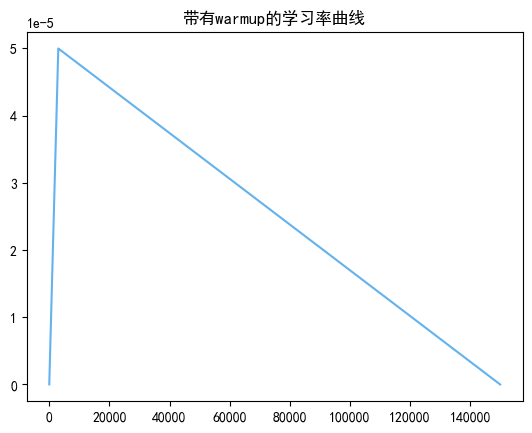

In [267]:
# 绘制学习率曲线
lr = []
for i in range(150000):
    lr_scheduler.step()
    lr.append(lr_scheduler.get_lr())
plt.title("带有warmup的学习率曲线")
plt.plot(lr,color='#63b2ee')

In [36]:
loss = pd.read_csv("./result/loss.csv")

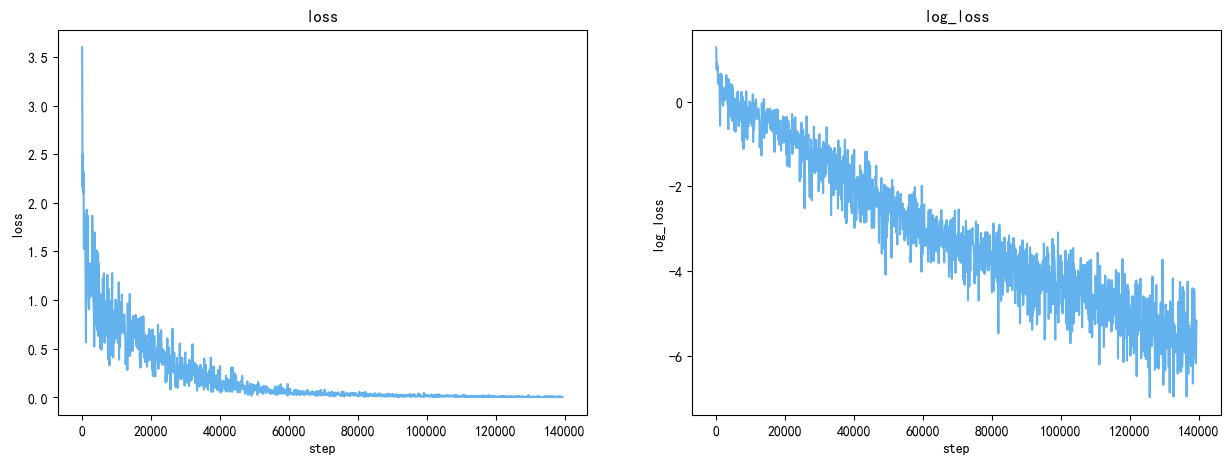

In [37]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(loss["id"],loss["value"],color='#63b2ee')
plt.xlabel("step")
plt.ylabel("loss")
plt.title("loss")
plt.subplot(1, 2, 2)
log_loss = np.log(loss["value"])
plt.xlabel("step")
plt.ylabel("log_loss")
plt.title("log_loss")
plt.plot(loss["id"],log_loss,color='#63b2ee')